# Ch5. 고급 합성곱 신경망 구조

## 5.1 CNN의 디자인 패턴

##### CNN 구조에서의 기본적인 패턴
1. 첫번째 패턴 - 특징 추출과 분류
    - 특징 추출을 맡는 부분 / 분류를 맡는 부분으로 나뉨
2. 두번째 패턴 - 이미지 깊이는 증가, 크기는 감소
    - 각 층은 이전 층에서 생성된 새로운 이미지에 합성곱 연산을 적용
    - 깊이 = 색상 채널 (color channel) : 이전 층에서 추출된 특징을 나타내는 특징 맵이 됨 (깊이가 1이라면 회색조 이미지, 3이면 컬러 이미지)
    - 크기는 감소한다? : 최대 풀링 등으로 이미지의 크기가 감소됨
3. 세번째 패턴 - 전결합층
    - 앞의 첫번째와 두번째 패턴은 반드시 지켜져야 하지만, 세번째 패턴은 반드시 지켜지지는 않음
    - 유닛 수가 증가하는 경우는 매우 드뭄, 보통 유닛 수가 같거나 감소함

https://www.manning.com/books/deep-learning-for-vision-systems <br>
https://github.com/moelgendy/deep_learning_for_vision_systems

## 5.2 LeNet-5

##### LeNet-5 : 가중치를 가진 5개의 층 (3개의 합성곱층과 2개의 전결합층)으로 구성
##### 구조 : 입력 이미지 -> C1 -> TANH -> S2 -> C3 -> TANH -> S4 -> C5 -> TANH -> FC6 -> SOFTMAX7
##### C : 합성곱층 / S : 풀링층(서브샘플링층) / FC : 전결합층
###### 98년도에는 ReLU가 딥러닝에 사용되지 않음, 은닉층 유닛의 활성화 함수는 tanh와 시그모이드 함수 사용

In [1]:
# 실습을 위한 세팅
# Load MNIST Database
from keras.datasets import mnist

# use Keras to import pre-shuffled MNIST database
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("The MNIST database has a training set of %d examples." % len(X_train))
print("The MNIST database has a test set of %d examples." % len(X_test))

The MNIST database has a training set of 60000 examples.
The MNIST database has a test set of 10000 examples.


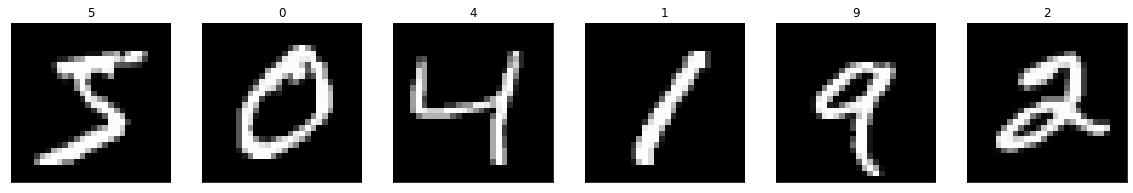

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

# plot first six training images
fig = plt.figure(figsize=(20,20))
for i in range(6):
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(str(y_train[i]))

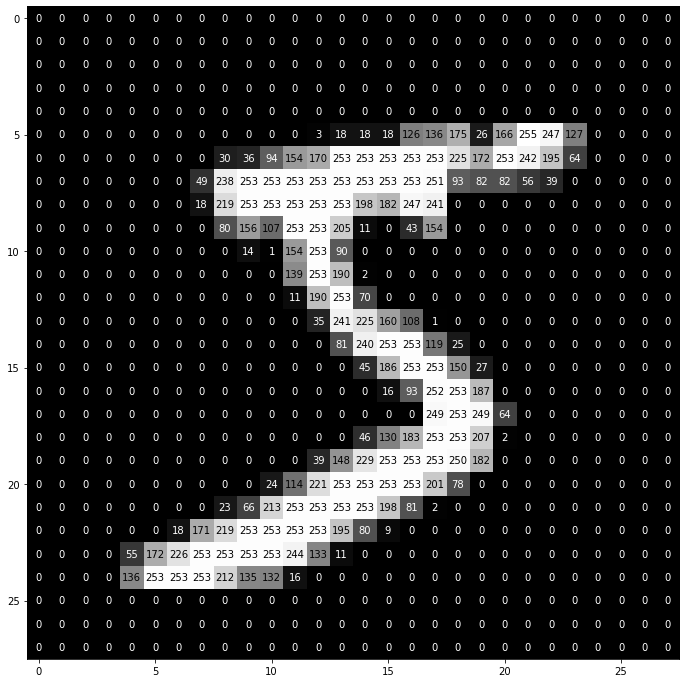

In [3]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

In [4]:
# normalize the data to accelerate learning
mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_test = (X_test-mean)/(std+1e-7)

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [5]:
from keras.utils import np_utils

num_classes = 10 
# print first ten (integer-valued) training labels
print('Integer-valued labels:')
print(y_train[:10])

# one-hot encode the labels
# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

# print first ten (one-hot) training labels
print('One-hot labels:')
print(y_train[:10])

Integer-valued labels:
[5 0 4 1 9 2 1 3 1 4]
One-hot labels:
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [6]:
# input image dimensions 28x28 pixel images. 
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('image input shape: ', input_shape)
print('x_train shape:', X_train.shape)

image input shape:  (28, 28, 1)
x_train shape: (60000, 28, 28, 1)


In [7]:
# 케라스로 LeNet-5 구현하기
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

#Instantiate an empty model
model = Sequential()

# C1 Convolutional Layer
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))

# S2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C3 Convolutional Layer
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

# S4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# C5 Fully Connected Convolutional Layer
model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))

#Flatten the CNN output so that we can connect it with fully connected layers
model.add(Flatten())

# FC6 Fully Connected Layer
model.add(Dense(84, activation='tanh'))

# Output Layer with softmax activation
model.add(Dense(10, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [8]:
# the loss function is categorical cross entropy since we have multiple classes (10) 


# compile the model by defining the loss function, optimizer, and performance metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

# set the learning rate schedule as created in the original paper
def lr_schedule(epoch):
    if epoch <= 2:     
        lr = 5e-4
    elif epoch > 2 and epoch <= 5:
        lr = 2e-4
    elif epoch > 5 and epoch <= 9:
        lr = 5e-5
    else: 
        lr = 1e-5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# set the checkpointer
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[checkpointer, lr_scheduler], 
          verbose=2, shuffle=True)

Epoch 1/20

Epoch 1: val_loss improved from inf to 0.08672, saving model to model.weights.best.hdf5
1875/1875 - 11s - loss: 0.2306 - accuracy: 0.9339 - val_loss: 0.0867 - val_accuracy: 0.9704 - lr: 5.0000e-04 - 11s/epoch - 6ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.08672 to 0.05812, saving model to model.weights.best.hdf5
1875/1875 - 11s - loss: 0.0760 - accuracy: 0.9770 - val_loss: 0.0581 - val_accuracy: 0.9806 - lr: 5.0000e-04 - 11s/epoch - 6ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.05812 to 0.03697, saving model to model.weights.best.hdf5
1875/1875 - 10s - loss: 0.0533 - accuracy: 0.9833 - val_loss: 0.0370 - val_accuracy: 0.9876 - lr: 5.0000e-04 - 10s/epoch - 6ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.03697 to 0.03487, saving model to model.weights.best.hdf5
1875/1875 - 10s - loss: 0.0322 - accuracy: 0.9902 - val_loss: 0.0349 - val_accuracy: 0.9871 - lr: 2.0000e-04 - 10s/epoch - 6ms/step
Epoch 5/20

Epoch 5: val_loss did not improve from 0.03487
1

In [10]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [11]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 99.0300%


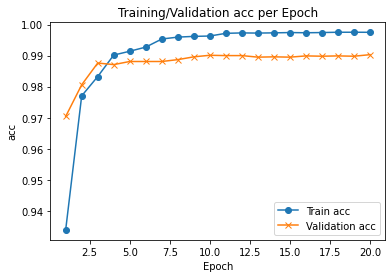

In [12]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['accuracy'], 'o-')
ax.plot([None] + hist.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')
plt.show()

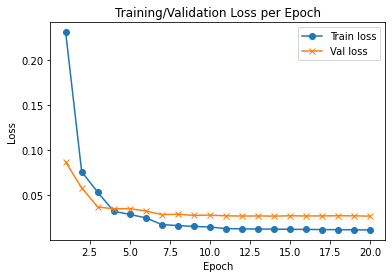

In [13]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot([None] + hist.history['loss'], 'o-')
ax.plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax.legend(['Train loss', "Val loss"], loc = 0)
ax.set_title('Training/Validation Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
plt.show()